In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys

In [6]:
IMAGES_PATH = os.path.join('./images/')
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
df = pd.read_csv('breast-cancer.csv')
df.shape

(569, 32)

In [8]:
sum(df.isna().sum())

0

In [9]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
pd.unique(df['diagnosis'])

array(['M', 'B'], dtype=object)

In [11]:
df.diagnosis = pd.Categorical(df.diagnosis)
df['label'] = df.diagnosis.cat.codes
dict(enumerate(df.diagnosis.cat.categories))

{0: 'B', 1: 'M'}

In [12]:
df.dtypes

id                            int64
diagnosis                  category
radius_mean                 float64
texture_mean                float64
perimeter_mean              float64
area_mean                   float64
smoothness_mean             float64
compactness_mean            float64
concavity_mean              float64
concave points_mean         float64
symmetry_mean               float64
fractal_dimension_mean      float64
radius_se                   float64
texture_se                  float64
perimeter_se                float64
area_se                     float64
smoothness_se               float64
compactness_se              float64
concavity_se                float64
concave points_se           float64
symmetry_se                 float64
fractal_dimension_se        float64
radius_worst                float64
texture_worst               float64
perimeter_worst             float64
area_worst                  float64
smoothness_worst            float64
compactness_worst           

In [13]:
from sklearn.metrics import classification_report
import random
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score,train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.manifold import TSNE
import time
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [14]:
! conda list | grep learn

scikit-learn              0.24.2           py39ha9443f7_0  
scikit-learn-intelex      2021.3.0         py39h06a4308_0  


# reshaffling the data

In [15]:
np.random.seed(42)
train = df.sample(frac=1)
Y = train['label']
X = train.drop(['diagnosis', 'id','label'],axis=1)
print(X.shape, Y.shape)

(569, 30) (569,)


# Standardize data after training and testing split

In [16]:
# standardize the test dataset using mean and std from x_train to aviod leaking
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size = 0.2)
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
#X_normalized = pd.concat([x_train,x_test], ignore_index = True)

In [17]:
print(x_train.shape, x_test.shape)

(455, 30) (114, 30)


Saving figure dist_bc


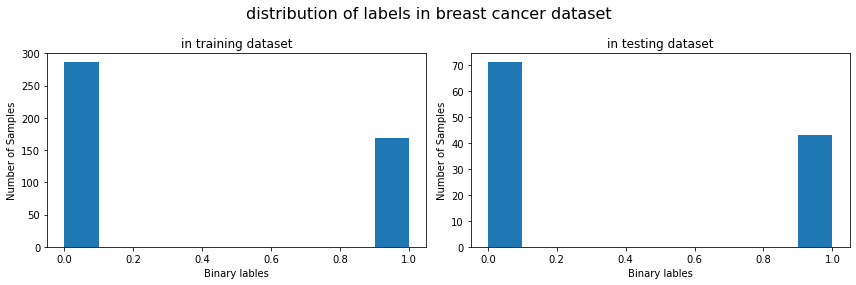

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(12, 4))
fig.suptitle('distribution of labels in breast cancer dataset', fontsize=16)
axes[0].hist(y_train)
axes[0].set_xlabel("Binary lables")
axes[0].set_ylabel("Number of Samples")
axes[1].set_xlabel("Binary lables")
axes[1].set_ylabel("Number of Samples")
axes[0].title.set_text('in training dataset')
axes[1].hist(y_test)
axes[1].title.set_text('in testing dataset')
save_fig("dist_bc")


# Choosing the number of dimensions to reduce

In [90]:
pca = PCA()
pca.fit(x_train)
#X_reduced = pca.fit_transform(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d
#X_reduced.shape

10

In [91]:
exp_var_pca = pca.explained_variance_ratio_

In [92]:
exp_var_pca

array([4.41496113e-01, 1.91405538e-01, 9.42367919e-02, 6.80501311e-02,
       5.19480042e-02, 4.05870817e-02, 2.24481991e-02, 1.60320203e-02,
       1.39045582e-02, 1.15945077e-02, 9.47920855e-03, 8.88561842e-03,
       8.28667868e-03, 5.37074210e-03, 2.84042970e-03, 2.53399498e-03,
       2.10774872e-03, 1.75493871e-03, 1.69423466e-03, 1.09076084e-03,
       9.76123897e-04, 8.96411921e-04, 8.16497003e-04, 5.80572689e-04,
       4.72906732e-04, 2.25715233e-04, 1.99773205e-04, 5.31978989e-05,
       2.63687186e-05, 5.13300075e-06])

Saving figure bc_pca_captured


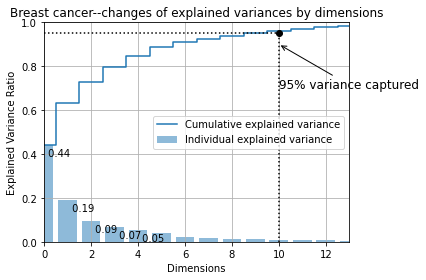

In [115]:
plt.figure(figsize=(6,4))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cumsum)), cumsum, where='mid',label='Cumulative explained variance')
plt.axis([0, 13, 0, 1])
for i, line in enumerate(exp_var_pca):
    x, y = i, line
    text = ' {:.2f}'.format(y)
    plt.annotate(text, xy=(x+0.05, y-0.05))
plt.xlabel("Dimensions")
plt.legend(loc='best')
plt.ylabel("Explained Variance Ratio")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")

plt.plot(d, 0.95, "ko")
plt.annotate("95% variance captured", xy=(d, 0.90), xytext=(d, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.title("Breast cancer--changes of explained variances by dimensions")

save_fig("bc_pca_captured")


# use PCA to visualize high-dimensional dataset

In [94]:
pca = PCA(n_components=3)
df_2D = pca.fit_transform(x_train)

In [95]:
df_2D.shape

(455, 3)

In [96]:
pca.explained_variance_ratio_

array([0.44149611, 0.19140554, 0.09423679])

In [97]:
df_2D = pd.DataFrame(df_2D)
df_2D['label'] = pd.DataFrame.reset_index(pd.DataFrame(y_train),drop=True)
df_2D = df_2D.rename(columns={0:'PC1',1:'PC2',2:'PC3'})
df_2D.head

<bound method NDFrame.head of           PC1       PC2       PC3  label
0   -1.710776  0.856668 -1.999597      0
1   -2.968223  1.775246  2.536985      0
2   -5.630044 -0.255379  4.047510      0
3   -1.192353 -1.626298 -0.339595      0
4   -1.026191 -1.982535 -1.118544      0
..        ...       ...       ...    ...
450  1.109128  0.947899 -2.304211      1
451 -1.475565  0.609560 -1.698893      0
452 -2.423283 -1.371515 -0.275276      0
453 -1.419749  0.181398 -0.218112      0
454  2.769085 -4.147348  1.383123      1

[455 rows x 4 columns]>

['0', '1']
Saving figure bc_pca_2d


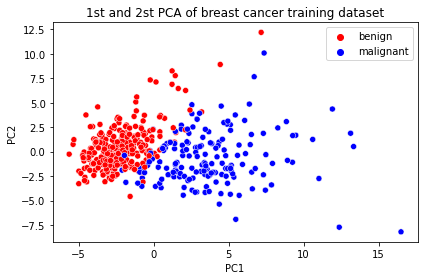

In [98]:
g = sns.scatterplot(x=df_2D['PC1'], y=df_2D['PC2'], hue=df_2D['label'], palette=['r','b'])
legend_labels, _= g.get_legend_handles_labels()
print(_)
g.legend(legend_labels,['benign', 'malignant'])
g.set(title='1st and 2st PCA of breast cancer training dataset')
save_fig("bc_pca_2d")

#ax.set_xlabel("PC1")
#ax.set_ylabel("PC2")
#ax.legend(loc='upper right')
#ax.set_title("1st and 2st PCA of swarm behavior training dataset")

In [99]:
list(pd.unique(df_2D['label']))

[0, 1]

['[0, 1]']
Saving figure bc_pca_3d


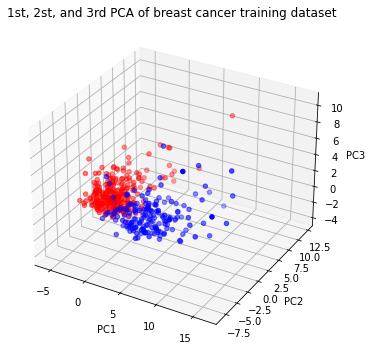

In [100]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

color_dict={0:'r', 1:'b'}
fig = plt.figure(figsize=(6, 5))

ax = plt.subplot(111, projection='3d')

ax.scatter(df_2D['PC1'], df_2D['PC2'], df_2D['PC3'], c = [color_dict[i] for i in df_2D['label']], \
           label=list(i for i in pd.unique(df_2D['label'])))
legend_labels, _= ax.get_legend_handles_labels()
print(_)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("1st, 2st, and 3rd PCA of breast cancer training dataset")
#ax.legend()
save_fig("bc_pca_3d")


# Start to train a binary classifier

In [101]:
t0 = time.time()
clf = RandomForestClassifier(max_depth=3, random_state=42)
clf.fit(x_train,y_train)
y_pred=clf.predict(x_test)
t1 = time.time()
time_before_pca = t1-t0
print("Random forest took {:.5f}s.".format(t1 - t0))

Random forest took 0.12774s.


In [102]:
confusion_matrix(y_test, y_pred)

array([[68,  3],
       [ 2, 41]])

In [103]:
f1_before_pca = f1_score(y_test, y_pred)
f1_before_pca

0.942528735632184

pca = PCA()
pca.fit(x_train)
#X_reduced = pca.fit_transform(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d# Retrain the classifier with datasets after PCA transformation to the optimal dimension (captured 95% variance)

In [104]:
pca = PCA(n_components = d)
X_reduced = pca.fit_transform(x_train)
X_test_reduced = pca.fit_transform(x_test)

In [105]:
X_recovered = pca.inverse_transform(X_reduced)
X_recovered

array([[-0.37494652, -1.171005  , -0.36744637, ..., -0.15834265,
         0.26742287,  0.979068  ],
       [-1.22644666,  0.76936993, -1.17024743, ..., -0.91524313,
         0.03397785,  0.31565839],
       [-2.07515263, -1.41311351, -2.15598975, ..., -1.61614793,
        -0.91254601, -1.03772938],
       ...,
       [-0.24347896, -0.59514765, -0.28022161, ..., -0.60184463,
        -0.38461503, -0.70900855],
       [-0.26517281, -0.14598938, -0.25046342, ..., -0.12795071,
        -0.43051202,  0.17089238],
       [ 1.6388311 ,  0.73695922,  1.58551575, ...,  0.3395011 ,
        -1.46684491, -1.78566593]])

In [106]:
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
result=cosine_similarity(np.asarray(X_recovered).reshape(1,-1),np.asarray(x_train).reshape(1,-1))
result

array([[0.64912141]])

In [107]:
t0 = time.time()
clf2 = RandomForestClassifier(max_depth=3, random_state=42)
clf2.fit(X_reduced,y_train)
y_pred2=clf2.predict(X_test_reduced)
t1 = time.time()
time_after_pca = t1-t0

print("Random forest took {:.5f}s.".format(t1 - t0))

Random forest took 0.11395s.


In [108]:
confusion_matrix(y_test, y_pred2)

array([[69,  2],
       [ 4, 39]])

In [109]:
f1_after_pca = f1_score(y_test, y_pred2)
f1_after_pca

0.9285714285714286

In [110]:
f1_variance = (f1_after_pca-f1_before_pca)/f1_before_pca*100
time_variance = (time_after_pca-time_before_pca)/time_before_pca*100


In [111]:
print(f1_variance, time_variance)

-1.480836236933802 -10.796253058527764


Saving figure bc_roc


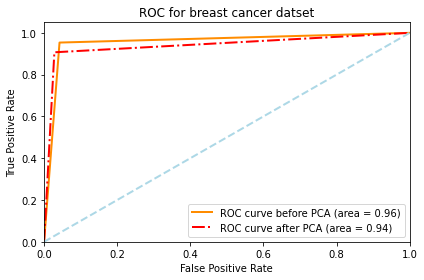

In [113]:
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0], tpr[0], _ = roc_curve(y_test, y_pred)
roc_auc[0] = auc(fpr[0], tpr[0])
fpr[1], tpr[1], _ = roc_curve(y_test, y_pred2)
roc_auc[1] = auc(fpr[1], tpr[1])

#fpr["micro1"], tpr["micro1"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
#roc_auc["micro1"] = auc(fpr["micro1"], tpr["micro1"])
#all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
#lw = 1
#mean_tpr = np.zeros_like(all_fpr)
#print(all_fpr)
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve before PCA (area = %0.2f)" % roc_auc[0],
)
plt.plot(
    fpr[1],
    tpr[1],
    color="red",
    linestyle='-.',
    lw=lw,
    label="ROC curve after PCA (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="lightblue", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for breast cancer datset")
plt.legend(loc="lower right")

save_fig("bc_roc")
